In [1]:
from glob import glob
import numpy as np
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def calibrate_camera():
    cal_w = 9
    cal_h = 6

    obj_points = []
    img_points = []

    # Creating array of object points
    points = np.zeros((cal_w * cal_h, 3), dtype=np.float32)
    for i in range(cal_w):
        points[i::cal_w, 1] = i
    for i in range(cal_h):
        points[i * cal_w:(i + 1) * cal_w, 0] = i

    # Take all images in camera_cal firectory
    for image in glob('camera_cal/*.jpg'):
        img = mpimg.imread(image)

        # Using RGB because image is read with matplotlib.image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

        # Trying to find all corners on an image
        ret, corners = cv2.findChessboardCorners(gray, (cal_w, cal_h), None)
        if ret:
            # If found -- save for calibrating camera
            obj_points.append(points)
            img_points.append(corners)

    # Run the calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    
    return (mtx, dist) # We return both calibration matrices as a single tuple for easier usage

In [3]:
def undistort_image(img, calibration_info):
    return cv2.undistort(img, calibration_info[0], calibration_info[1], None, calibration_info[0])

In [4]:
def to_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2].astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2].astype(np.uint8)
    
    # Sobel x, we take only the red component, because it 
    sobelx = cv2.Sobel(img[:,:,0], cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 25
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = s_channel.mean() * 1.2
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold vibrance channel
    v_thresh_min = 110
    v_thresh_max = 255
    v_channel[v_channel < v_thresh_min] = 0
    v_channel = cv2.blur(v_channel, (5,5))
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh_min) & (v_channel <= v_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((v_binary, sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (v_binary == 1)] = 1
    
    return color_binary, combined_binary

# Utility method to return only the combined binary (for the final pipeline)
def to_binary_mask(img):
    _, combined_binary = to_binary(img)
    return combined_binary

In [5]:
# Transform image perspective before looking for lane lines
def get_transform_src(img_size):
    return np.float32(
        [[(img_size[0] / 2) - 60, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 20), img_size[1]],
        [(img_size[0] * 5 / 6) + 20, img_size[1]],
        [(img_size[0] / 2 + 60), img_size[1] / 2 + 100]])

def get_transform_dst(img_size):
    return np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

def transform_perspective(img, inverse=False):
    img_size = img.shape[:2:][::-1]

    src = get_transform_src(img_size)
    dst = get_transform_dst(img_size)

    M = cv2.getPerspectiveTransform(src, dst) if inverse == False else cv2.getPerspectiveTransform(dst, src)

    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

In [6]:
# Returns lines (and optionally additional info for visualization) found on the image
def get_lines(binary_warped, windows=None, left_points=None, right_points=None):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_fit = None
    right_fit = None
    
    left_fits = []
    right_fits = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Save window for visualization
        if windows is not None:
            windows.append(((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)))
            windows.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.extend(good_left_inds)
        right_lane_inds.extend(good_right_inds)
        
        #Evaluate the line so far
        if (window >= nwindows / 2):
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            if len(leftx > minpix) and len(lefty > minpix):
                left_fit = np.polyfit(lefty, leftx, 2)
                left_fits.append(left_fit)

            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 
            if len(rightx > minpix) and len(righty > minpix):
                right_fit = np.polyfit(righty, rightx, 2)
                right_fits.append(right_fit)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        else:
            if left_fit is not None:
                y_val = binary_warped.shape[0] - (window + .5) * window_height
                leftx_current = int(np.polyval(left_fit, y_val))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            if right_fit is not None:
                y_val = binary_warped.shape[0] - (window + .5) * window_height
                rightx_current = int(np.polyval(right_fit, y_val))
        
    # Fit a second order polynomial to each
    left_fit = np.array(left_fits).mean(axis=0)
    right_fit = np.array(right_fits).mean(axis=0)
    
    if left_points is not None:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        left_points.extend([leftx, lefty])
        
    if right_points is not None:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        right_points.extend([rightx, righty])
        
    return (left_fit, right_fit)

In [7]:
# Returns closest element in the array to the specified vector's curvature
def get_closest(array, vector):
    distances = []
    for element in array:
        distances.append(abs(element[0] - vector[0]))
    return array[np.array(distances).argmin()]

# Return new lines based on ones found 
def get_next_lines(binary_warped, left_fit, right_fit, smooth_a = .1, left_points=None, right_points=None):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    image_height = binary_warped.shape[0]
    nwindows = 9
    window_height = np.int(image_height/nwindows)
    
    left_fits = []
    right_fits = []
    
    windows = [
        (image_height / 2, image_height),
        (0, image_height / 2),
        (image_height / 4, 3 * image_height / 4),
        (0, image_height) # Full image is the last one because we will return it to visualization
    ]
    
    
    # Step through the windows one by one
    for win_y_low, win_y_high in windows:
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin)) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)) & (nonzeroy >= win_y_low) & (nonzeroy < win_y_high))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        if len(lefty) > 0 and len(leftx) > 0:
            left_fits.append(np.polyfit(lefty, leftx, 2))
        if len(righty) > 0 and len(rightx) > 0:
            right_fits.append(np.polyfit(righty, rightx, 2))
    
    if len(left_fits) > 0:
        new_left_fit = get_closest(left_fits, left_fit)
    else:
        new_left_fit = left_fit
        
    if len(right_fits) > 0:
        new_right_fit = get_closest(right_fits, right_fit)
    else:
        new_right_fit = right_fit
    
    # Add exponential smoothing
    new_left_fit = [smooth_a * new_value + (1 - smooth_a) * old_value for new_value, old_value in zip(new_left_fit, left_fit)]
    new_right_fit = [smooth_a * new_value + (1 - smooth_a) * old_value for new_value, old_value in zip(new_right_fit, right_fit)]
    
    if left_points is not None:
        left_points.extend([leftx, lefty])
        
    if right_points is not None:
        right_points.extend([rightx, righty])
    
    return new_left_fit, new_right_fit

In [8]:
def get_curvature_and_offset(left_fit, right_fit, image_width, image_height):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, image_height-1, image_height)

    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)

    y_eval = image_height - 1

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculating offset
    left_bottom = np.polyval(left_fit, y_eval)
    right_bottom = np.polyval(right_fit, y_eval)
    lane_center = (right_bottom + left_bottom) / 2
    image_center = image_width / 2

    offset = (image_center - lane_center) * xm_per_pix

    return left_curverad, right_curverad, offset

In [9]:
# Camera calibration takes some time, so we do it once globally in a separate cell
calibration_info = calibrate_camera()

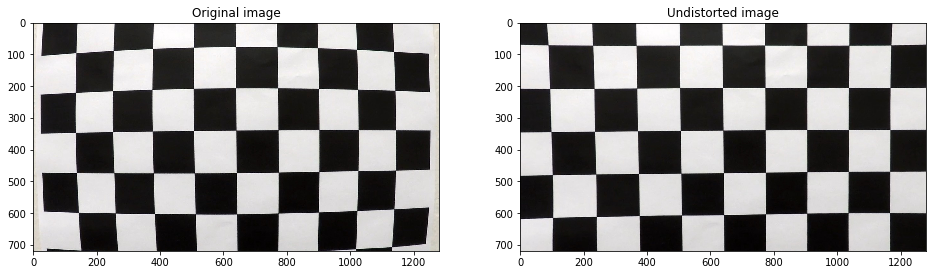

In [10]:
# Undistort a sample image
image = glob('camera_cal/*.jpg')[0]
img = mpimg.imread(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_title('Original image')
_ = ax1.imshow(img)

img_corrected = undistort_image(img, calibration_info)

ax2.set_title('Undistorted image')
_ = ax2.imshow(img_corrected)

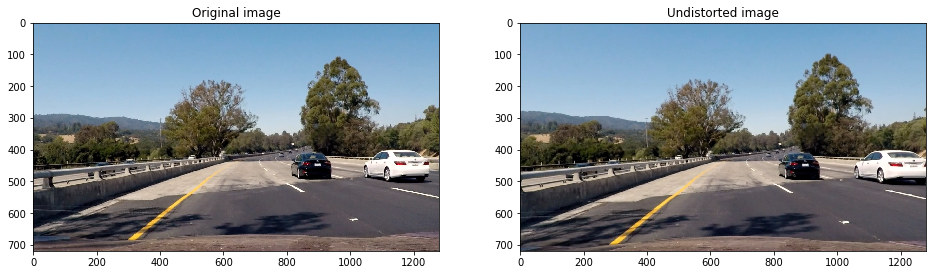

In [11]:
img = mpimg.imread('test_images/test4.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
ax1.set_title('Original image')
ax1.imshow(img)

img_undistorted = undistort_image(img, calibration_info)

ax2.set_title('Undistorted image')
ax2.imshow(img_undistorted)

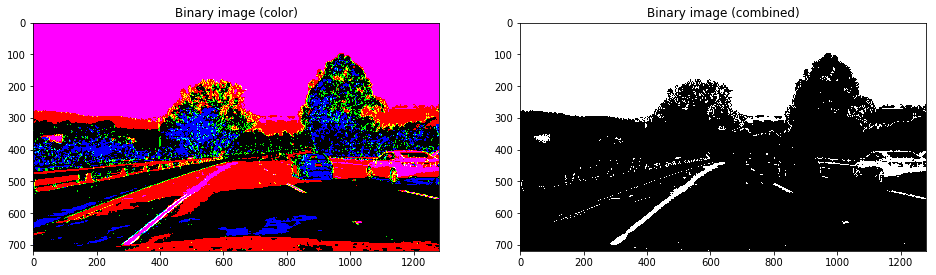

In [12]:
color_binary, combined_binary = to_binary(img_undistorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('Binary image (color)')
ax1.imshow(color_binary)

ax2.set_title('Binary image (combined)')
ax2.imshow(combined_binary, cmap='gray')

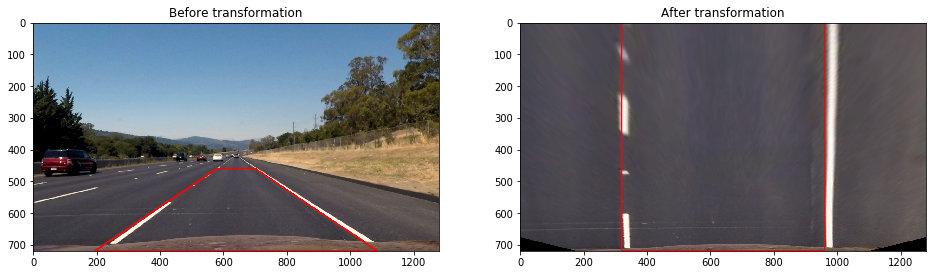

In [13]:
img = mpimg.imread('test_images/straight_lines2.jpg')

img_undistorted = undistort_image(img, calibration_info)

warped = transform_perspective(img_undistorted)
img_copy = img_undistorted.copy()

img_size = img_undistorted.shape[:2:][::-1]
src = get_transform_src(img_size)
dst = get_transform_dst(img_size)

cv2.polylines(img_copy, [src.reshape(-1,1,2).astype(np.int32)], True, (255, 0, 0), thickness=3, lineType=cv2.LINE_AA)
cv2.polylines(warped, [dst.reshape(-1,1,2).astype(np.int32)], True, (255, 0, 0), thickness=3, lineType=cv2.LINE_AA)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.set_title('Before transformation')
ax1.imshow(img_copy)

ax2.set_title('After transformation')
ax2.imshow(warped)

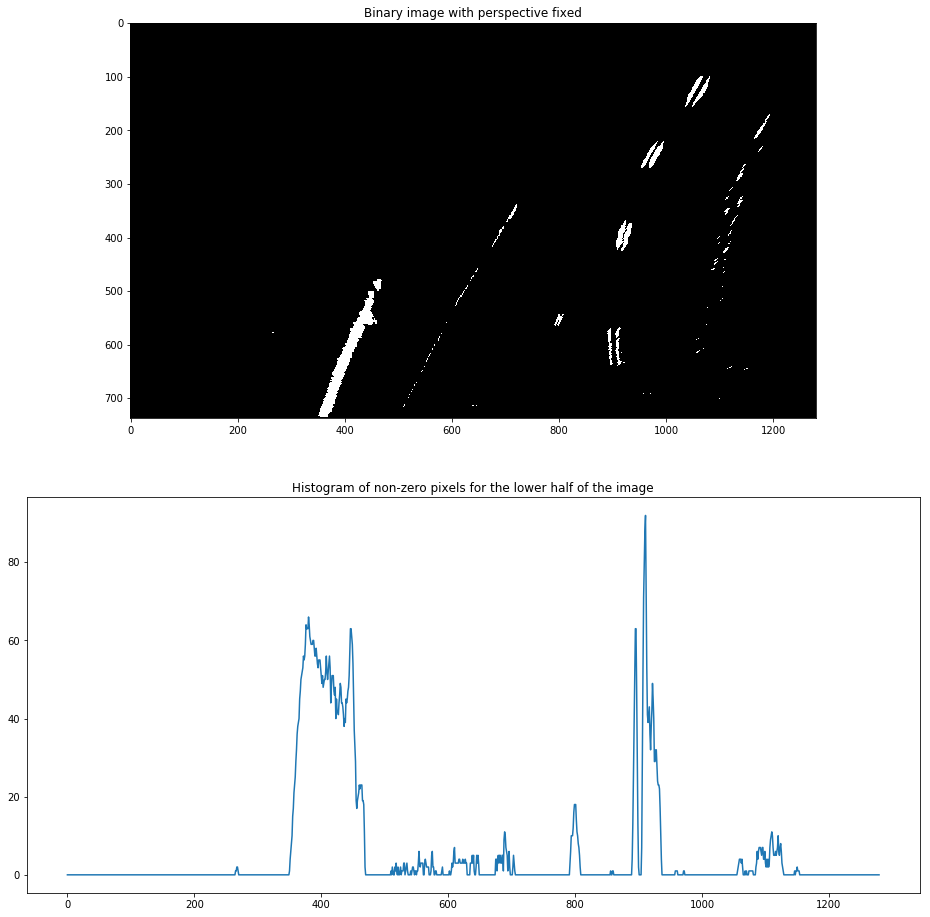

In [14]:
# Use different image (with line curvature) to illustrate polynomial fit
img = mpimg.imread('test_images/challenge_4.jpg')
img_undistorted = undistort_image(img, calibration_info)
combined_binary = to_binary_mask(img_undistorted)

binary_warped = transform_perspective(combined_binary)
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 16))
ax1.set_title('Binary image with perspective fixed')
ax1.imshow(binary_warped, cmap='gray')

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
ax2.set_title('Histogram of non-zero pixels for the lower half of the image')
ax2.plot(histogram)

(738, 1280, 3)


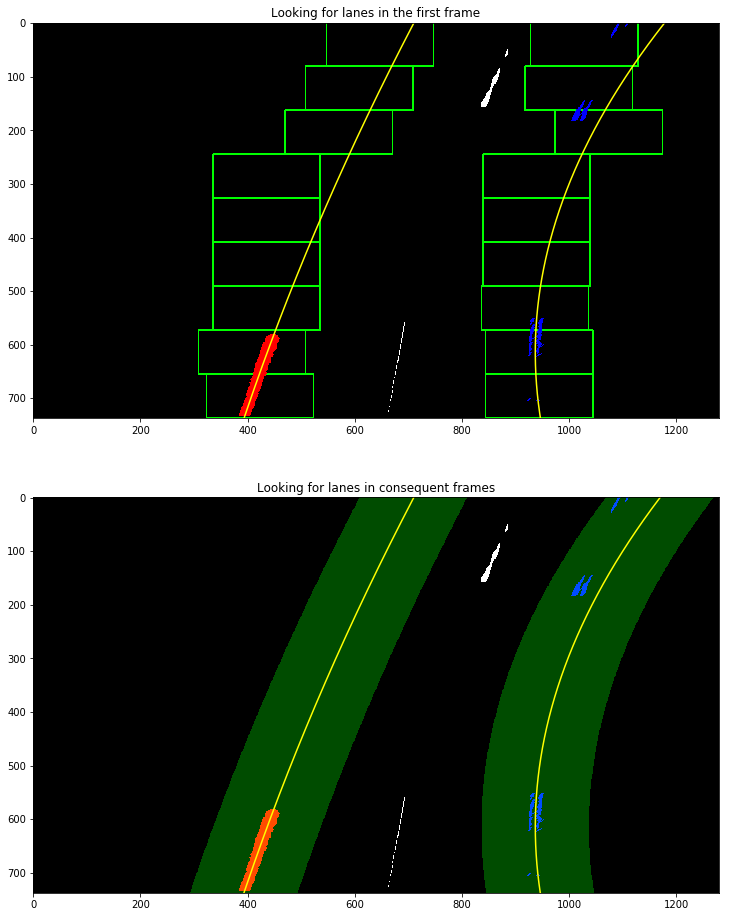

In [15]:
img = mpimg.imread('test_images/challenge_3.jpg')
print(img.shape)
img_undistorted = undistort_image(img, calibration_info)
combined_binary = to_binary_mask(img_undistorted)

binary_warped = transform_perspective(combined_binary)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

windows = []
left_points = []
right_points = []

(left_fit, right_fit) = get_lines(binary_warped, windows=windows, left_points=left_points, right_points=right_points)

(leftx, lefty) = tuple(left_points)
(rightx, righty) = tuple(right_points)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rectangle in windows:
    cv2.rectangle(out_img, rectangle[0], rectangle[1], (0,255,0), 2) 

out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
fig, (ax1, ax2) = plt.subplots(2, figsize=(16,16))
ax1.imshow(out_img)
ax1.set_title('Looking for lanes in the first frame')
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')

# Now illustrate finding lines in the next frame (we use the same one, but for video it will be the next one)
left_points = []
right_points = []
left_fit, right_fit = get_next_lines(binary_warped, left_fit, right_fit, left_points=left_points, right_points=right_points)

(leftx, lefty) = tuple(left_points)
(rightx, righty) = tuple(right_points)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100

left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
ax2.imshow(result)
ax2.set_title('Looking for lanes in consequent frames')
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

In [16]:
# Final pipeline
g_calibration_info = None
g_line_left = None
g_line_right = None
g_frame = 0

def reset_pipeline():
    global g_calibration_info, g_line_left, g_line_right, g_frame
    g_calibration_info = calibrate_camera()
    g_line_left = None
    g_line_right = None 
    g_frame = 0

def process_image(img):
    
    global g_calibration_info, g_line_left, g_line_right, g_frame
    
    smooth_a = .2
    
    img_undistorted = undistort_image(img, g_calibration_info)
    combined_binary = to_binary_mask(img_undistorted)
    binary_warped = transform_perspective(combined_binary)
    
    if g_line_left is not None and g_line_right is not None:
        (g_line_left, g_line_right) = get_next_lines(binary_warped, g_line_left, g_line_right)
    else:
        (g_line_left, g_line_right) = get_lines(binary_warped)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = g_line_left[0]*ploty**2 + g_line_left[1]*ploty + g_line_left[2]
    right_fitx = g_line_right[0]*ploty**2 + g_line_right[1]*ploty + g_line_right[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transform_perspective(color_warp, inverse=True) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistorted, 1, newwarp, 0.3, 0)
    
    image_width, image_height = tuple(img.shape[:2][::-1])
    left_rad, right_rad, offset = get_curvature_and_offset(g_line_left, g_line_right, image_width, image_height)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Left lane line curvature is %.02f meters' % left_rad, 
               (20, 40), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, 'Right lane line curvature is %.02f meters' % right_rad, 
               (20, 80), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    direction = 'right' if offset > 0 else 'left'
    cv2.putText(result, 'Car offset in the lane is %.02f meters to the %s' % (abs(offset), direction), 
               (20, 120), font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    
    g_frame += 1
    
    return result

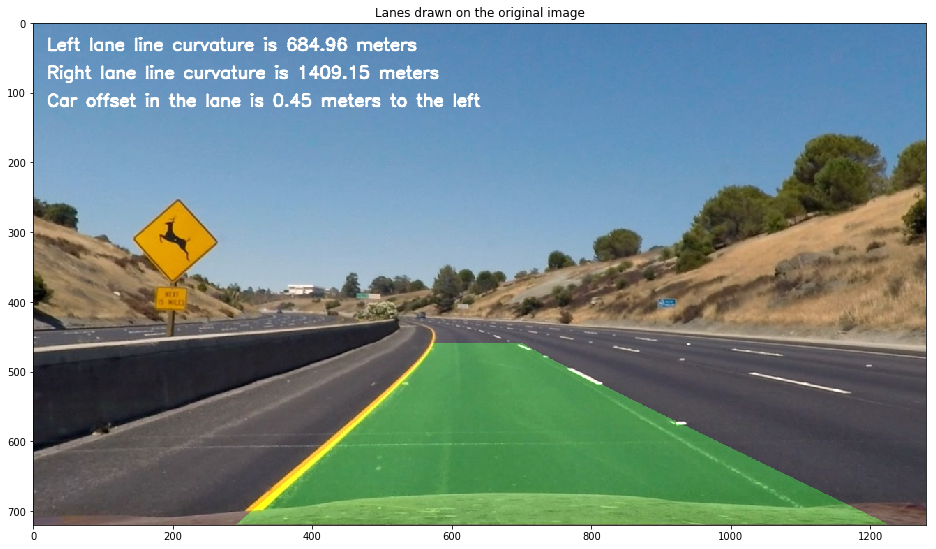

In [17]:
# Testing pipeline on a single image
img = mpimg.imread('test_images/test2.jpg')
reset_pipeline()
result = process_image(img)
fig, ax = plt.subplots(1, figsize=(16,10))
ax.imshow(result)
ax.set_title('Lanes drawn on the original image')

In [18]:
# Applying pipeline to the video
reset_pipeline()
os.makedirs('test_videos_output', exist_ok=True)
output = 'test_videos_output/project_video.mp4'
clip = VideoFileClip('project_video.mp4')
clip_processed = clip.fl_image(process_image)
%time clip_processed.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [02:06<00:00, 10.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 4min 32s, sys: 33.7 s, total: 5min 5s
Wall time: 2min 7s
